# Classification of Animals in 10 classes

## Importing Libraries

In [2]:
# Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import keras.callbacks as callbacks

# ResNet50 fine-tuning
from keras.applications.resnet_v2 import ResNet50V2
from keras.models import Model

# Data processing and visualization (+ utils)
import os
import matplotlib.pyplot as plt

## Loading the dataset

Importing the dataset and defining train and test sets

In [3]:
def datagen_augmented(img_path, img_size, batch_size, val_split, seed):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                      rotation_range=10,
                                                                      height_shift_range=0.1,
                                                                      width_shift_range=0.1,
                                                                      horizontal_flip=True,
                                                                      validation_split=val_split,
                                                                      zoom_range=0.1)
        
    train = image_generator.flow_from_directory(img_path,
                                                target_size=img_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                seed=seed)

    val = image_generator.flow_from_directory(img_path,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation',
                                              seed=seed)

    return train, val


def datagen(img_path, img_size, batch_size, val_split, seed):
    train = tf.keras.utils.image_dataset_from_directory(
        img_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=val_split,
        subset='training',
        seed=seed
        )

    val = tf.keras.utils.image_dataset_from_directory(
        img_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=val_split,
        subset='validation',
        seed=seed
        )
    
    def process(image,label):
        image = tf.cast(image/255., tf.float32)
        return image, label

    train = train.map(process)
    val = val.map(process)
    
    return train, val

In [4]:
img_path = os.path.join(os.getcwd(), 'raw-img')
img_size = (224,224)
batch_size = 32
val_split = 0.2
seed = 21

# train, val = datagen(img_path, img_size, batch_size, val_split, seed)
train, val = datagen_augmented(img_path, img_size, batch_size, val_split, seed)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


Getting labels names (for visualization)

In [5]:
label_names = ('cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo')
print(label_names)

('cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo')


Note that the labels are in italian and are traslated in english in the following code: <br>
"cane" = "dog", "cavallo" = "horse", "elefante" = "elephant", "farfalla" = "butterfly", "gallina" = "hen", \
"gatto" = "cat", "mucca" = "cow", "pecora" = "sheep", "ragno" = "spider", "scoiattolo" = "squirrel" 

## Building the model

First off let's define the model architecture

Then we compile the model

In [6]:
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.trainable = False

x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=x)

In [7]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='../models/resnet50/resnet50.{epoch:02d}-{val_accuracy:.2f}.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),

    callbacks.EarlyStopping(
        monitor='val_accuracy',
#         min_delta=0.0001,
        patience=5,
        restore_best_weights=True,
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3
    )
]

In [8]:
resnet_model.compile(
    loss=CategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

## 6. Model Training

In [10]:
resnet_model_history = resnet_model.fit(
    train,
    validation_data=val,
    callbacks=callbacks_list,
    epochs=5
)

Epoch 1/5
655/655 [==============================] - 1268s 2s/step - loss: 1.5990 - accuracy: 0.8347 - val_loss: 0.3219 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 2/5
655/655 [==============================] - 1232s 2s/step - loss: 0.5974 - accuracy: 0.8600 - val_loss: 0.3117 - val_accuracy: 0.9186 - lr: 0.0010
Epoch 3/5
655/655 [==============================] - 1187s 2s/step - loss: 0.5364 - accuracy: 0.8691 - val_loss: 0.3043 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 4/5
655/655 [==============================] - 1018s 2s/step - loss: 0.4772 - accuracy: 0.8862 - val_loss: 0.2924 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 5/5
655/655 [==============================] - 959s 1s/step - loss: 0.4813 - accuracy: 0.8875 - val_loss: 0.2919 - val_accuracy: 0.9295 - lr: 0.0010


In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 256)      0

## 7. Visualizing the models performance over the epochs

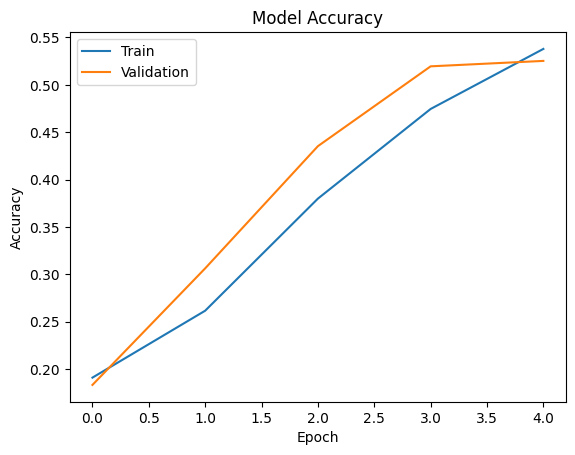

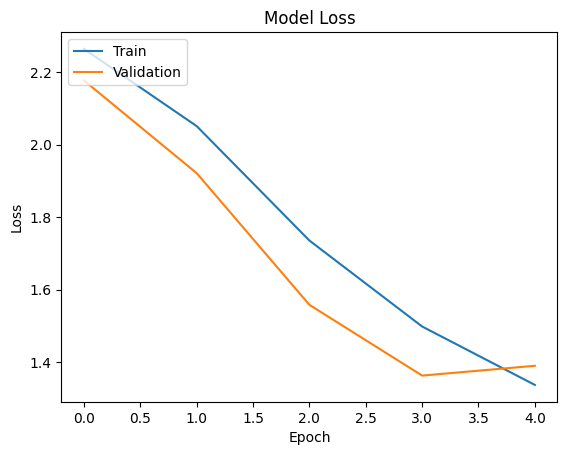

In [19]:
# plotting the training and validation accuracy
plt.plot(.history['accuracy'])
plt.plot(.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plotting the training and validation loss
plt.plot(.history['loss'])
plt.plot(.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = resnet_model.predict(val)
y_pred = np.argmax(y_pred, axis=1)
y_true = val.classes
cm = confusion_matrix(y_true, y_pred)
print(cm)

# classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))

# saving the model
resnet_model.save('../models/resnet50/resnet50.h5')

In [ ]:
# use the model to infer on a single image
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

img_path = os.path.join(os.getcwd(), 'raw-img', 'cane', 'cane_0001.jpg')
img = image.load_img(img_path, target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255.

model = load_model('../models/resnet50/resnet50.h5')
prediction = model.predict(img)
print(prediction)
print(np.argmax(prediction, axis=1))
print(label_names[np.argmax(prediction, axis=1)[0]])


è una cane

# The end